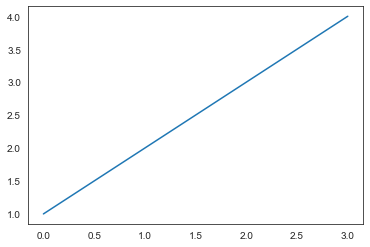

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pprint import pprint
%matplotlib inline

sns.set_style("white")
plt.plot(np.arange(1,5));

# USE ogbl-biokg?


In [2]:
from ogb.linkproppred import LinkPropPredDataset
d_name = "ogbl-biokg"
dataset = LinkPropPredDataset(name = d_name)

split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]
graph = dataset[0] # graph: library-agnostic graph object


In [3]:
print(f'Unique rels: {len(graph["edge_index_dict"].keys())}')

Unique rels: 51


In [4]:
from ogb.linkproppred import Evaluator

evaluator = Evaluator(name = d_name)
print(evaluator.expected_input_format)
print(evaluator.expected_output_format)


==== Expected input format of Evaluator for ogbl-biokg
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edge, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edge, num_nodes_neg). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges. It needs to be a 2d matrix.
y_pred_pos[i] is ranked among y_pred_neg[i].
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.
==== Expected output format of Evaluator for ogbl-biokg
{'hits@1_list': hits@1_list, 'hits@3_list': hits@3_list, 
'hits@10_list': hits@10_list, 'mrr_list': mrr_list}
- mrr_list (list of float): list of scores for calculating MRR 
- hits@1_list (list of float): list of scores for calculating Hits@1 
- hits@3_list (list of float): list of scores to

In [5]:
max(graph['edge_index_dict'][('author',
   'affiliated_with',
   'institution')][0])

KeyError: ('author', 'affiliated_with', 'institution')

In [ ]:
#graph

In [5]:
from scipy.sparse import csc_matrix
from sympy import nextprime

relid2prime = {}
prime2relid = {}
current_int = 2

data_edges, rows, cols = [], [], []
N_nodes = sum(list(graph['num_nodes_dict'].values()))
for rel, indexes in graph['edge_index_dict'].items():
    cur_prime = int(nextprime(current_int))
    relid2prime[rel] = cur_prime
    prime2relid[cur_prime] = rel
    current_int = cur_prime

    rows.extend(indexes[0].tolist())
    cols.extend(indexes[1].tolist())
    data_edges.extend([cur_prime for _ in indexes[0]])

adj_ = csc_matrix((data_edges, (rows, cols)), dtype=int, shape=(N_nodes, N_nodes))

In [6]:
import time
power = 1
adj_power = [adj_]
for p in range(1, power + 1):
    print(adj_power[-1].shape)
    time_s = time.time()
    adj_power.append(adj_power[-1] * adj_)
    print(f'Calculated Adj. for power: {p} in {time.time() - time_s:.2f} seconds!')

(93773, 93773)
Calculated Adj. for power: 1 in 24.76 seconds!


In [ ]:
graph

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier


pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
    #('sd', StandardScaler()),
    #('clf', LinearSVC(C=100, class_weight='balanced'),)
])
pipe.fit(feats2[train_idx['paper']], y_train)
print(f'Fitted')
y_pred = pipe.predict(feats2[test_idx['paper']])
print(f'Predict')

In [ ]:
input_dict = {"y_true": label['paper'][test_idx['paper'].flatten()].reshape(-1,1),
              "y_pred": y_pred.reshape(-1,1)}
result_dict = evaluator.eval(input_dict)
print(result_dict)

Try out idea with A' = [A | A.T] (Nx2N) and learnable matrices: W (2N x N) that complete
A' x W = A.

A' = [A[i,:] | A[:,i]] concatenated the feature vectors of incmoming and outgoing for each node.
Also. this is for power == 1. We can have multiple W_p for different A'_p


# of unique rels: 3 	 | # of unique nodes: 4


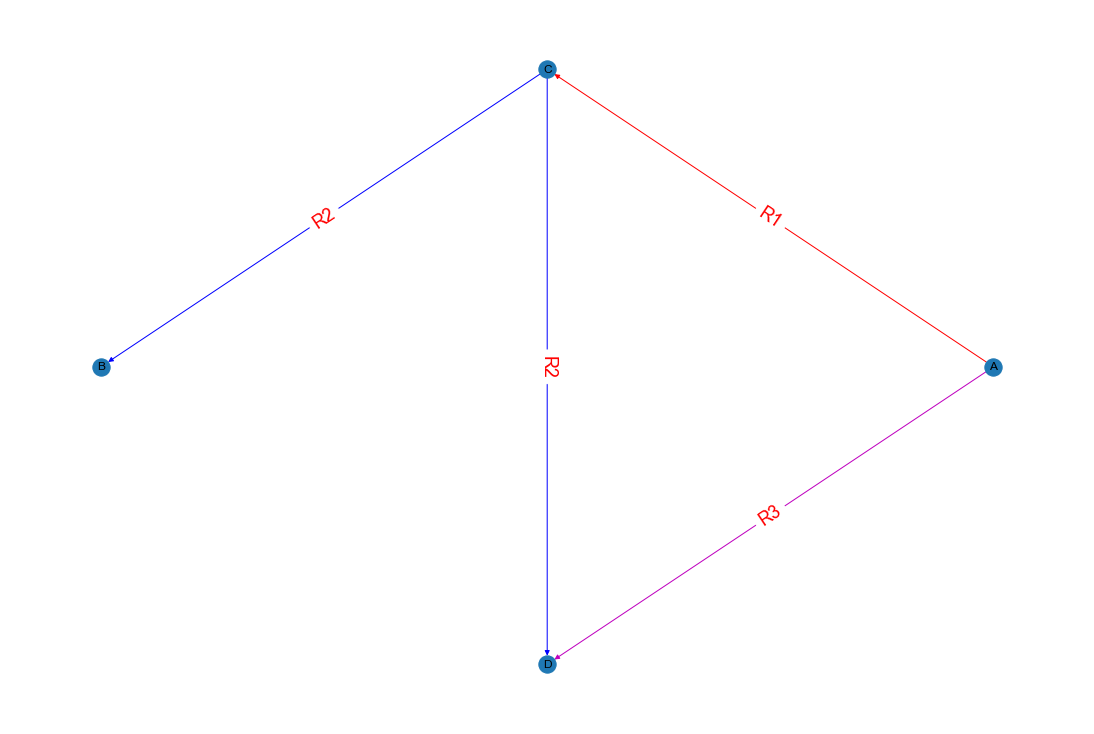

In [50]:
import networkx as nx
triples = [
    ("A", 'R1', 'C'),
    ('C', 'R2', 'B'),
    ('C', 'R2', 'D'),
    ('A', 'R3', 'D'),
]
triples_df = pd.DataFrame.from_records(triples, columns=['head', 'rel', 'tail'])

unique_rels = sorted(triples_df['rel'].unique())
unique_nodes = sorted(set(triples_df['head'].values.tolist() + triples_df['tail'].values.tolist()))
print(f'# of unique rels: {len(unique_rels)} \t | # of unique nodes: {len(unique_nodes)}')

G = nx.from_pandas_edgelist(triples_df, source='head', target='tail', edge_attr='rel', create_using=nx.MultiDiGraph())

colormap = {
    'R1': 'r',
    'R2': 'b',
    'R3': 'm'
}

pos = nx.circular_layout(G)
edges = G.edges()

colors = []
edge_labels = {}
for (u,v,attrib_dict) in list(G.edges.data()):
    colors.append(colormap[attrib_dict['rel']])
    edge_labels[(u,v)] = attrib_dict['rel']

plt.figure(figsize=(15,10))
nx.draw(G, pos, edge_color=colors, with_labels = True)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='red', font_size=18)
plt.axis('off')
plt.show()

Let's say that the rule is R1(X,Y) ^ R2(Y,Z) => R3(Z,X).
We have A confirming this rule so we expect the second power adj to be able to get this.


In [51]:
unique_nodes = sorted(list(G.nodes()))
node2id = {}
id2node = {}
for i, node in enumerate(unique_nodes):
    node2id[node] = i
    id2node[i] = node

from sympy import nextprime, primefactors
relid2prime = {}
prime2relid = {}
current_int = 2
unique_rels = sorted(triples_df['rel'].unique())
for rel in unique_rels:
    cur_prime = nextprime(current_int)
    relid2prime[rel] = cur_prime
    prime2relid[cur_prime] = rel
    current_int = cur_prime
print(relid2prime)

{'R1': 3, 'R2': 5, 'R3': 7}


In [52]:
from scipy.sparse import csc_matrix
A = np.zeros((len(unique_nodes), len(unique_nodes)), dtype=np.int64)
for i, row in triples_df.iterrows():
    A[node2id[row['head']], node2id[row['tail']]] = relid2prime[row['rel']]
A_clipped = A.copy().clip(0, 1)

max_order = 5
power_A = [csc_matrix(A)]
power_A_clipped = [csc_matrix(A_clipped)]

for _ in range(1,max_order):
    power_A.append(power_A[-1] * csc_matrix(A))
    power_A_clipped.append(power_A_clipped[-1] *csc_matrix(A_clipped))
power_A[0].toarray()

array([[0, 0, 3, 7],
       [0, 0, 0, 0],
       [0, 5, 0, 5],
       [0, 0, 0, 0]])

In [53]:
power_A[1].toarray()

array([[ 0, 15,  0, 15],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])

In [54]:
power_A[2].toarray()

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

We expect to learn a mapping of 15 to 7, so the missing link A-B with a 15->7 can be learnt.
Try:
1) Direct mapping learning
2) Learnable W

Q: Make symmetric?

In [61]:
from scipy.sparse import csc_matrix
from collections import defaultdict
relation_to_coord = defaultdict(list)
coord_to_relation = defaultdict(set)
rows, cols = power_A[0].nonzero()
for i, (row, col) in enumerate(zip(rows, cols)):
    relation_to_coord[power_A[0][row,col]].append((row, col))
    coord_to_relation[(row, col)].add(power_A[0][row,col])
    #print(i, row, col, power_A[0][row,col], power_A[0].data[i])

In [62]:
path_power_to_relation = {}
for p in range(1,max_order):
    path_power_to_relation[p] = defaultdict(set)
    rows, cols = power_A[p].nonzero()
    for i, (row, col) in enumerate(zip(rows, cols)):
         path_power_to_relation[p][power_A[p][(row, col)]] = path_power_to_relation[p][power_A[p][(row, col)]].union(coord_to_relation[(row, col)])

In [57]:
path_power_to_relation[1]

defaultdict(set, {15: {7}})

In [67]:
from collections import Counter
q = ('A', 'R3', 'B')
h_q, r_q, t_q = q

# Predicting probable tail:
rel_i = relid2prime[r_q]
h_i = unique_nodes.index(h_q)
coord_to_check = relation_to_coord[rel_i]
for t_i, t_predicted in enumerate(unique_nodes):
    pred = []
    for p in range(1, max_order):
        for (row, col) in coord_to_check:
            val = power_A[p][(row, col)]
            if rel_i in path_power_to_relation[p][val]:
                pred.append(t_predicted)
counter = Counter(pred)
total = sum(counter.values(), 0.0)
for key in counter:
    counter[key] /= total

print(f'Predicted tails: {counter}')

# Predicting probable head:
rel_i = relid2prime[r_q]
h_i = unique_nodes.index(h_q)
coord_to_check = relation_to_coord[rel_i]

rel_i = relid2prime[r_q]
h_i = unique_nodes.index(h_q)
coord_to_check = relation_to_coord[rel_i]
for t_i, t_predicted in enumerate(unique_nodes):
    pred = []
    for p in range(1, max_order):
        for (row, col) in coord_to_check:
            val = power_A[p][(row, col)]
            if rel_i in path_power_to_relation[p][val]:
                pred.append(t_predicted)
counter = Counter(pred)
total = sum(counter.values(), 0.0)
for key in counter:
    counter[key] /= total

print(f'Predicted heads: {counter}')

Predicted tails: Counter({'D': 1.0})


Try out on WN18RR using the 3-hop feature vector per edge in a multi-class setting?

